# VCノードの起動、削除

このNotebookではVCP SDKを利用してVCノードを起動、削除する手順を記しています。

## 概要

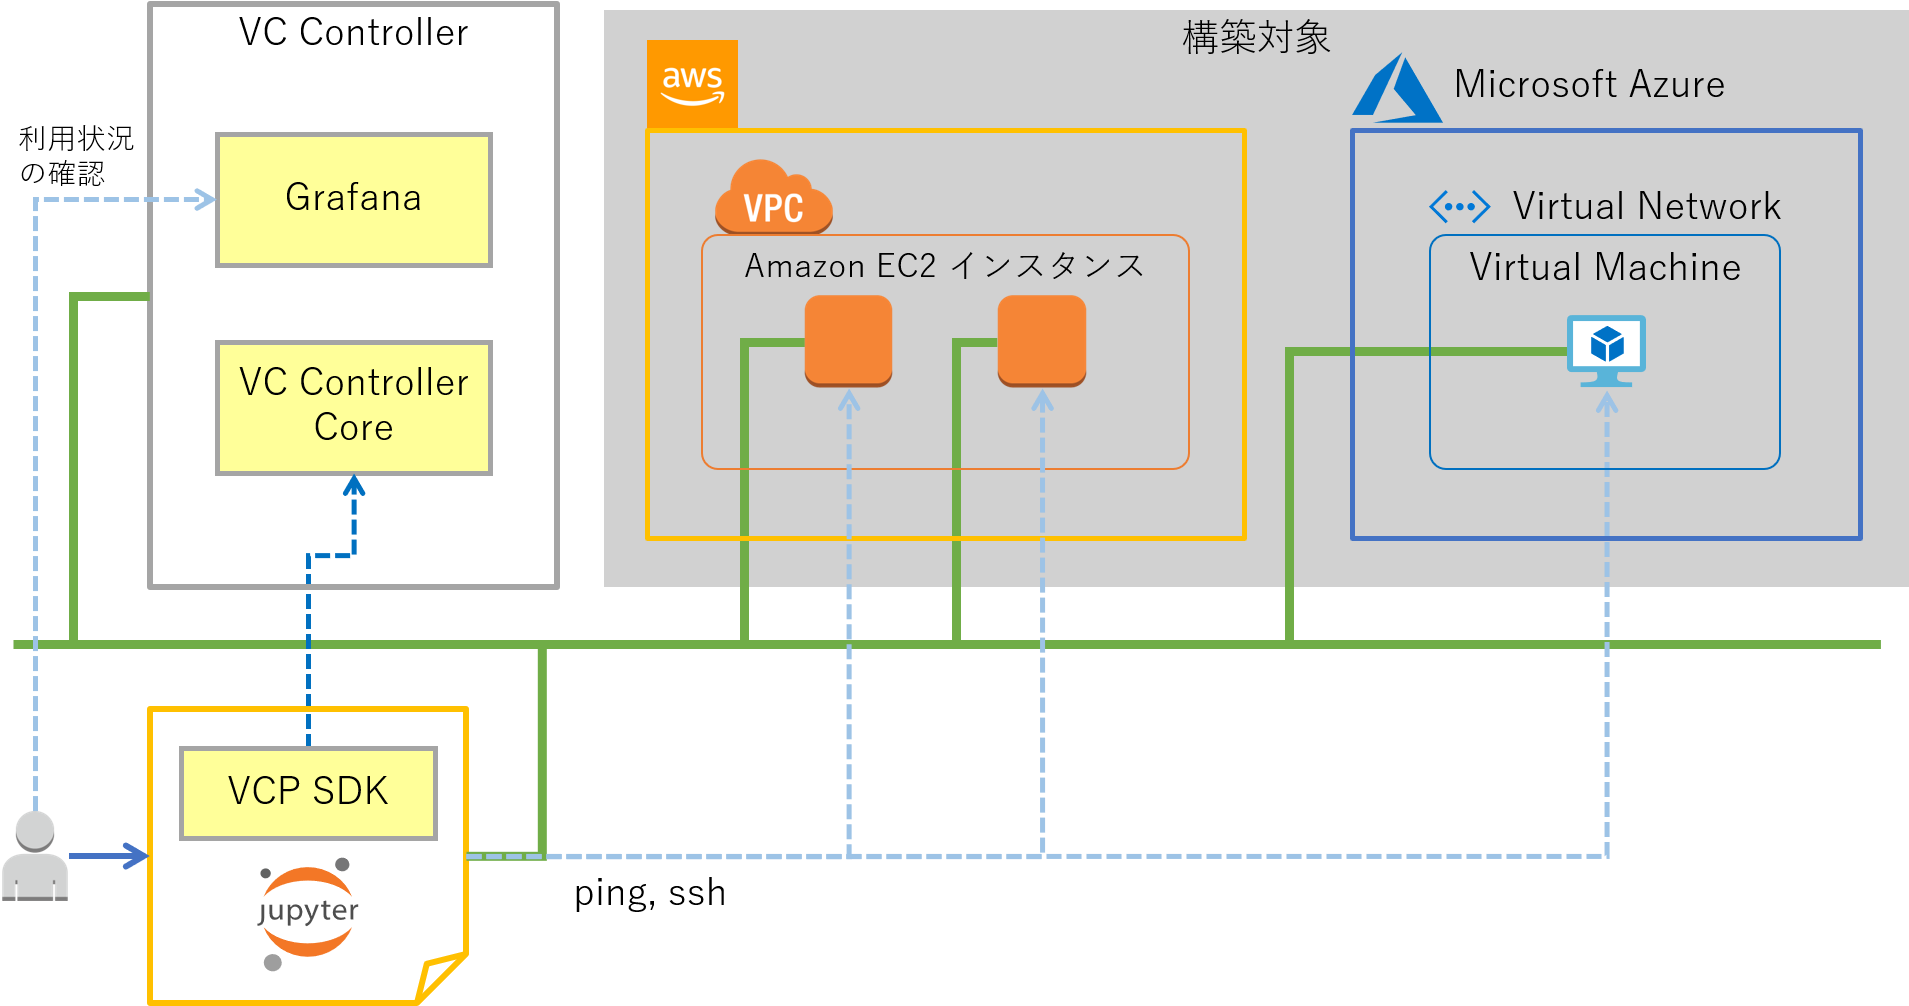

### 用語説明

上の図に記されている構成要素についての簡単な説明を以下に記します。

* VC Controller
  - VCPがユーザに対して提供しているサービス群
* VC Controller Core
  - ユーザからのAPI呼び出しを受けとりUnitGroupの作成、削除などを行う
* Grafana
  - 可視化ツール、ダッシュボードツール
  - VCP では VCノード のモニタリング状況を表示するのに利用している
* VCP SDK
  - VCPの機能を呼び出して VM/BM の作成、削除などを行うPython3のライブラリ
* [VPC](https://aws.amazon.com/jp/vpc/)
  - Amazon が提供している AWS 内の仮想プライベートネットワーク環境
* [Amazon EC2](https://aws.amazon.com/jp/ec2/)
  - Amazon が提供している仮想コンピューティング環境
* [Azure Virtual Network](https://azure.microsoft.com/ja-jp/services/virtual-network/)
  - Microsoft が提供しているクラウド内の仮想プライベートネットワーク環境
* [Azure Virtual Machine](https://azure.microsoft.com/ja-jp/services/virtual-machines/)
  - Microsoft が提供している仮想コンピューティング環境

## 操作手順

大まかな操作手順は以下のようになります。

1. VCP SDKを用いてVCノード(Amazon EC2 インスタンス)を起動する
1. 起動したVCノードに ssh でログインして操作する
1. GrafanaでVCノードの利用状況を確認する
1. Unit内のVCノードをスケールアウト、スケールインする
1. 別のパブリッククラウド(Microsoft Azure)のVCノードを起動する
1. 起動したVCノードをすべて削除する

# VCノード(Amazon EC2インスタンス)の起動

VCP SDKを用いてVCノード(Amazon EC2インスタンス)を起動します。また、起動したVCノードに対してsshでログインして操作を行います。

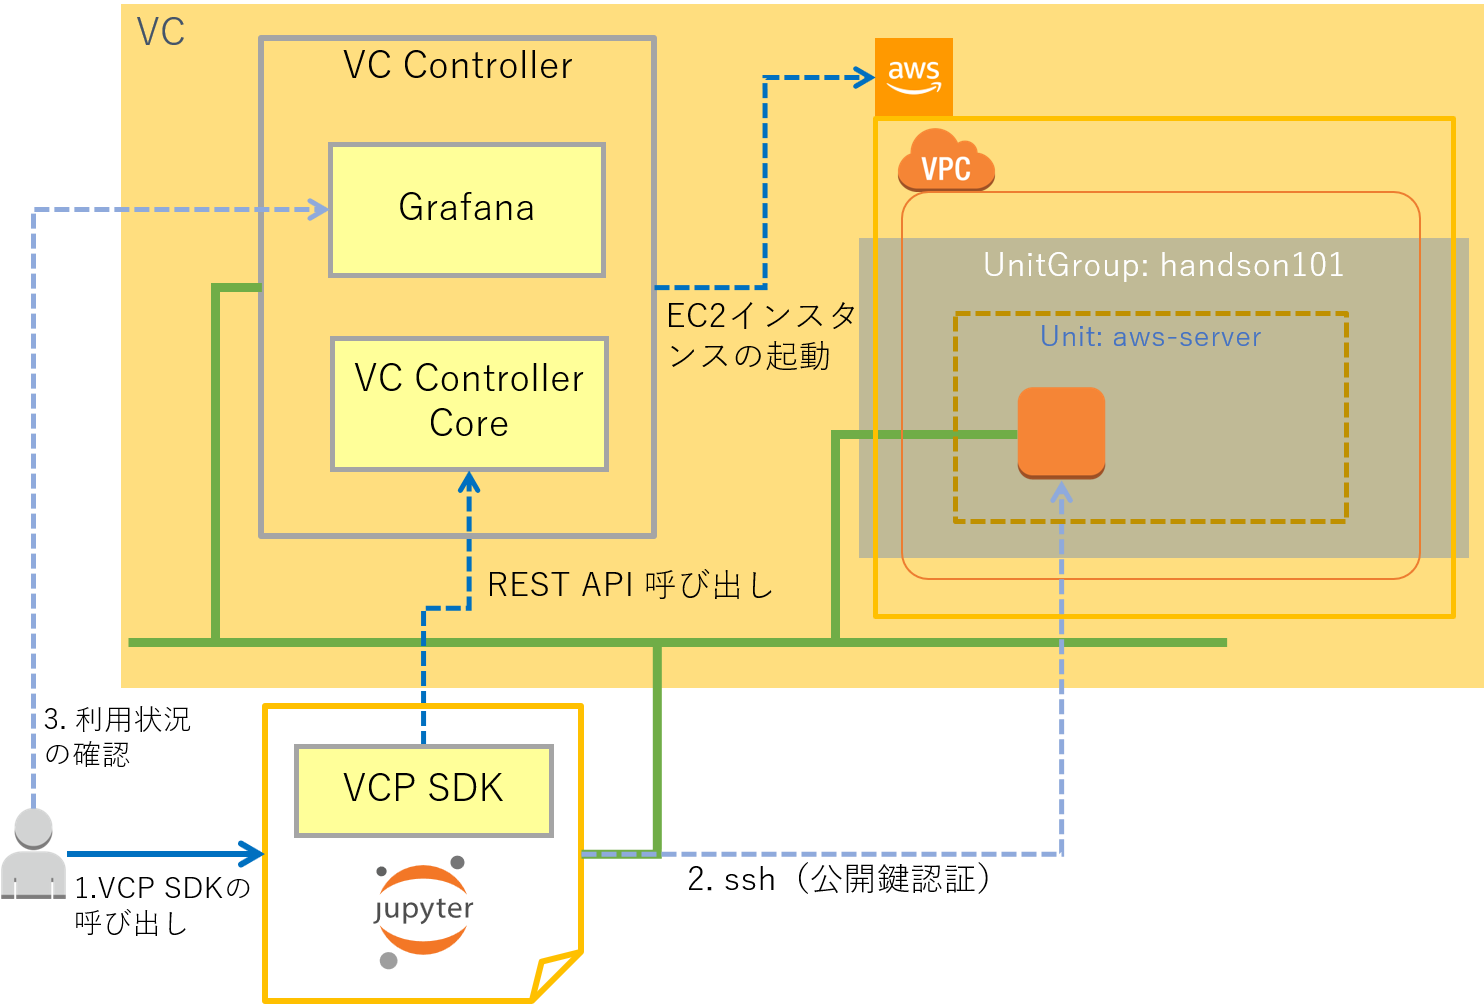

## アクセストークンの入力

VCP SDKを利用するにはVC Controllerのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンの値を入力してください。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


## VCP SDKの初期化

VCP SDKの初期化を行います。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK

# VCP SDKの初期化
vcp = VcpSDK(
    vcc_access_token,  # VCCのアクセストークン
)

上のセルの実行結果がエラーとなり以下のようなメッセージが表示されている場合は、入力されたアクセストークンに誤りがあります。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/XX/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

`vcp`からは UnitGroup の管理（作成、情報取得）や VCP SDK自体に関する情報取得を行うことができます。例えば、次のセルを実行するとUnitGroupの一覧が表示されます。

> まだUnitGroupを作成していないので、ヘッダー以外はなにも表示されないはずです。

In [3]:
# UnitGroupの一覧を DataFrame で表示する
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate


次のセルを実行すると VCP SDK と VC Controller のバージョンが表示されます。

In [4]:
vcp.version()

vcpsdk:
  version: 18.10.0+20180925
  filename: /notebooks/notebook/vcpsdk/vcpsdk.py
vc_controller:
  version: 18.08.0+20180731
  plugin:
    azure: 1.1+20180731
    sakura: 1.0+20180731
    abc: 1.1+20180731
    gcp: 1.0+20180731
    aic: 1.1+20180731
    aws: 1.1+20180731
  host: 10.0.0.1
  name: vcc3015
plugin:
  onpremises: 1.0+20180731
  azure: 1.1+20180731
  sakura: 1.0+20180731
  abc: 1.1+20180731
  gcp: 1.0+20180731
  aic: 1.1+20180731
  aws: 1.1+20180731
vcplib:
  version: 18.08.0+20180731
  filename: /notebooks/notebook/vcplib/occtr.py


## UnitGroupの作成

`handson101`という名前の UnitGroup を作成します。

In [5]:
# UnitGroupの作成
unit_group = vcp.create_ugroup(
    'handson101'                   # UnitGroupの名前
)

作成したUnitGroupの状態を表示してみます。

> UnitGroup の名前が `handson101` であることと、その状態が `RUNNING` であることなどが確認できるはずです。

In [6]:
print(unit_group)

unit group name: handson101

[Vc]
+ type[compute] name[handson101] vcno(36) state[RUNNING] vcid[2402ae36ff214307b26596a77118e75a]





UnitGroupの一覧を表示してみます。

In [7]:
# UnitGroupの一覧を DataFrame で表示する
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate
0,36,compute,handson101,RUNNING,2402ae36...,2018/09/28 05:33:28 UTC


## UnitGroupの状態を確認する

UnitGroupに属している Unit の一覧を表示します。

> まだ、このUnitGroupでは Unit を作成していないのでヘッダー以外は何も表示されません。

In [8]:
# Unitの一覧を DataFrame で表示する
unit_group.df_units()

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


UnitGroupに属しているVCノードの一覧を表示します。

> まだVCノードが存在していないので何も表示されません。

In [9]:
unit_group.df_nodes()

## VCノードのspecを指定する

Unitを構成するVCノードがどのような設定であるかを指定するためのオブジェクトとしてVCP SDKでは`spec`オブジェクトを用意しています。VCP SDKの利用者は`spec`オブジェクトのプロパティを設定することで Unitに起動するVCノードの設定内容を定義することができます。

`spec`オブジェクトの設定項目の例を以下に示します。

* 仮想マシンのインスタンスタイプ
  - m5.large, c5.large, ...
* 仮想マシンのルートボリュームサイズ(GiB)
* 仮想マシンに割り当てるプライベートIPアドレス
* Unit内に作成するVCノードの数

設定できる項目はクラウドプロバイダ(aws, azure, ...)毎に異なります。

### flavor

`spec`オブジェクトの全てのパラメータを毎回設定するのは煩雑になるので典型的な構成のパラメータセットを事前に定義しています。事前に定義した`spec`パラメータセットのことを VCP SDKでは `flavor`と呼んでいます。`spec`に設定できるパラメータはクラウドプロバイダ毎に異なるので `flavor`の定義もクラウドプロバイダ毎に行っています。

次のセルを実行すると aws用に定義している `flavor` の一覧が表示されます。

In [10]:
VcpSDK.df_flavors('aws')

,flavor,instance_type,volume_size,volume_type
0,small,m4.large,20,standard
1,medium,m4.xlarge,40,standard
2,large,m4.2xlarge,100,standard


### spec オブジェクトを作成する

specオブジェクトを作成します。specオブジェクトを作成するにはプロバイダと`flavor`を指定します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `small`

In [11]:
spec = VcpSDK.get_spec('aws', 'small')

作成した`spec`の設定内容を確認してみます。

> `instance_type`パラメータに `flavor` の指定と対応するEC2インスタンスタイプ`m4.large`が設定されていることが確認できるはずです。
> `volume_size`, `volume_type`についてもそれぞれ`flavor`と対応する値が設定されます。

In [12]:
print(spec)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': [], 'v': []}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


`spec`に対しては `flavor`で指定するだけではなく個々のパラメータを直接指定することもできます。例えば、以下のようなものが指定できます。

* num_nodes
  - Unit内に作成するVCノードの数: デフォルト=1
* ip_address_list
  - VCノードに割り当てるプライベートIPアドレス
  - このパラメータを指定しない場合は利用可能なアドレスが自動的に割り当てられる
* instance_type
  - Amazon EC2のインスタンスタイプ
  - flavorで設定されているもの以外を利用したい場合に指定する
* volume_size
  - Amazon EC2インスタンスのルートボリュームに割り当てるサイズ(GiB)
  - flavorで設定されているもの以外を利用したい場合に指定する
* volume_type
  - Amazon EC2インスタンスのルートボリュームのEBSタイプ
  - flavorで設定されているもの以外を利用したい場合に指定する

試しに `volume_size`を指定してみます。

In [13]:
spec.volume_size = 15

指定した値が`spec`の設定に反映されていることを確認してみます。

In [14]:
print(spec)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': [], 'v': []}
    instance_type: m4.large
    volume_size: 15
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


`volume_size`の値が指定した値に変更されています。

### sshの鍵ファイルを設定する

VCノードにsshでログインするためには事前に公開鍵認証の鍵を登録する必要があります。そのための設定をここで行います。

VCノードに登録する公開鍵認証の**秘密鍵**のパスを次のセルで設定してください。

> VCノードに登録が必要となるのは公開鍵です。しかしsshでログインする際に指定する秘密鍵と一致するペアの公開鍵が指定されていないと、VCノードにログイン出来なくなってしまいます。そのような状況に陥るのを避けるために、ここでは秘密鍵のファイルから公開鍵を取り出してそれを`spec`オブジェクトに設定する手順を採ります。これにより鍵ペアがが正しいことが保証されます。

In [15]:
import os
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

`spec` に設定が必要となるのは公開鍵なので `ssh-keygen -y` コマンドで秘密鍵から公開鍵を取り出します。さらに公開鍵を`spec`が要求するフォーマット(Base64)に変換して `spec` オブジェクトに設定しています。

In [16]:
out = !ssh-keygen -y -f {ssh_private_key} | base64 -w 0         # 秘密鍵から公開鍵を取り出して Base64エンコードする
b64_ssh_public_key = out[0]

# specオブジェクトのパラメータに設定する
spec.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

SSHに関するパラメータが`spec`の設定に反映されたことを確認してみます。

In [17]:
print(spec)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
    instance_type: m4.large
    volume_size: 15
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


## Unitの作成とVCノードの起動

Unitを作成します。Unitを作成すると同時に VCノード（ここでは Amazon EC2インスタンス）が起動します。

> 処理が完了するまで1分半～2分程度かかります。

In [18]:
# Unitの作成（同時に VCノードが作成される）
unit = unit_group.create_unit(
    'aws-server',               # Unit名の指定
    spec
)

2018-09-28 14:36:04,017 - INFO - BOOTING ... 0 sec
2018-09-28 14:36:09,234 - INFO - BOOTING ... 5 sec
2018-09-28 14:36:14,466 - INFO - BOOTING ... 10 sec
2018-09-28 14:36:19,674 - INFO - BOOTING ... 15 sec
2018-09-28 14:36:24,869 - INFO - BOOTING ... 20 sec
2018-09-28 14:36:30,060 - INFO - BOOTING ... 25 sec
2018-09-28 14:36:35,257 - INFO - BOOTING ... 30 sec
2018-09-28 14:36:40,449 - INFO - BOOTING ... 35 sec
2018-09-28 14:36:45,652 - INFO - BOOTING ... 40 sec
2018-09-28 14:36:50,845 - INFO - BOOTING ... 45 sec
2018-09-28 14:36:56,054 - INFO - BOOTING ... 50 sec
2018-09-28 14:37:01,287 - INFO - BOOTING ... 55 sec
2018-09-28 14:37:06,490 - INFO - BOOTING ... 60 sec
2018-09-28 14:37:11,712 - INFO - BOOTING ... 65 sec
2018-09-28 14:37:16,928 - INFO - BOOTING ... 70 sec
2018-09-28 14:37:22,124 - INFO - BOOTING ... 75 sec
2018-09-28 14:37:27,325 - INFO - unit aws-server is RUNNING


UnitGroupに属しているUnitの一覧表示を行い、Unitが作成されていることを確認します。

In [19]:
# Unitの一覧を DataFrame で表示する
unit_group.df_units()

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,36,handson101,RUNNING,2402ae36...,2018/09/28 05:33:28 UTC,aws-server,RUNNING


UnitGroupに属しているVCノードの一覧表示を行い、VCノードが起動していることを確認します。VCノードが正常に起動していることは `node_state` の表示が `RUNNING`になっていることで確認できます。

In [20]:
# VCノードの一覧を DataFrame で表示する
unit_group.df_nodes()

,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none


ここでは VCノードの起動が完了するまで待ち合わせるモードでUnitの作成を行いましたが、非同期処理でUnit, VCノードの作成を行うこともできます。`create_unit()`の`wait_for`パラメータに`False`を指定すると非同期モードでのUnit, VCノードの作成を行います。

```
unit = unit_group.create_unit('aws-server', spec, wait_for=False)
```

非同期モードでUnitを作成した場合にUnitやVCノードが起動したことを確認するには、状態取得を行う以下に示す方法を利用してください。

1. `unit_group.df_nodes()`
  * Unitの一覧表示の`node_state`の項目で Unitの状態を確認できます
1. `unit.df_nodes()`, `unit_group.df_nodes()`
  * VCノードの一覧表示の`node_state`の項目で VCノードの状態を確認できます

起動処理が正常に完了すると、状態は`RUNNING`となります。

また、非同期モードでUnit作成を行った場合でも、以下のメソッドを利用することで後からVCノード起動の待ち合わせを行うことができます。
* `unit_group.wait_unit(unit_name)`
  - unit_nameで指定されたUnitの状態が `RUNNING` または `ERROR`になるのを待ちます

## 疎通確認

起動した VCノードに対して`ping`を行ってみます。

まずUnitGroup内で起動しているVCノードに割り当てられているプライベートIPアドレスの値を取得して変数 `ip_address`に格納します。

In [21]:
# unit_group.find_ip_addresses() は UnitGroup内の全VCノードのIPアドレスのリストを返します
ip_address = unit_group.find_ip_addresses()[0] # 今は１つのVCノードのみ起動しているので [0] で最初の要素を取り出す

print(ip_address)

172.30.2.26


実際に `ping` を行ってみます。

> Codeセルで先頭に `!` をつけるとシェルコマンドが実行できます。また `{}`で囲むことで Python の変数参照やコードの実行に置き換えることができます。詳しくは「[IPython Documentation](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#system-shell-commands)」などを参照してください。

In [22]:
!ping -c 5 {ip_address}

PING 172.30.2.26 (172.30.2.26): 56 data bytes
64 bytes from 172.30.2.26: icmp_seq=0 ttl=63 time=0.403 ms
64 bytes from 172.30.2.26: icmp_seq=1 ttl=63 time=0.289 ms
64 bytes from 172.30.2.26: icmp_seq=2 ttl=63 time=0.341 ms
64 bytes from 172.30.2.26: icmp_seq=3 ttl=63 time=0.266 ms
64 bytes from 172.30.2.26: icmp_seq=4 ttl=63 time=0.348 ms
--- 172.30.2.26 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev = 0.266/0.329/0.403/0.048 ms


# VCノードに ssh でログインして操作する

起動したVCノードに ssh でログインして操作を行います。

まずは `ls -la` を実行してみます。

In [23]:
!ssh \
    -i {ssh_private_key} \
    -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q \
    root@{ip_address} \
    ls -la

total 20
drwx------    6 root     root          4096 Sep 28 05:37 .
drwxr-xr-x   60 root     root          4096 Sep 28 05:37 ..
drwx------    3 root     root          4096 May  9 05:28 .cache
drwxr-xr-x    3 root     root          4096 May  9 05:28 .gem
drwx------    2 root     root          4096 Sep 28 05:37 .ssh


VCノードにsshでログインするにはsshの引数に以下の指定が必要となります。

* sshの identity ファイル（秘密鍵）
  - `spec`オブジェクトに設定した秘密鍵とおなじもの
* ユーザ名
  - `root`
* ログイン先のIPアドレス

さらにJupyter Notebook環境での操作の煩雑さを避けるため以下の指定も行っています。

* `-o StrictHostKeyChecking=no`
  - 新しいホスト鍵をユーザの known_hosts ファイルに自動的に追加します
* `-o UserKnownHostsFile=/dev/null`
  - ホスト鍵データベースとして使うファイルの指定
    - 仮想マシンの起動、削除を繰り返すと異なるマシンが同じIPアドレスで起動されることがありホスト鍵が異なると警告される場合があるので、登録されるホスト鍵を /dev/null に捨てるように設定しています
* `-q`
  - ほとんどの警告メッセージや診断メッセージが抑制されます

> 操作の煩雑さを避けるために追加で指定したオプションは**実際の運用時に指定するべきではありません**。実際の運用時には、Terminalを開いてホスト鍵データベースの登録を行ってください。

sshのオプションを毎回指定するのも煩雑なので変数に設定しておきます。

In [24]:
ssh_opts = "-i {} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q".format(ssh_private_key)

VCノードに対して`uname -a`, `df -h` などを実行してみます。

In [25]:
!ssh {ssh_opts} root@{ip_address} uname -a

Linux ip-172-30-2-26 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux


In [26]:
!ssh {ssh_opts} root@{ip_address} df -h

Filesystem                Size      Used Available Use% Mounted on
none                     14.6G      1.8G     12.1G  13% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/resolv.conf
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hostname
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker
none                      3.9G         0      3.9G   0% /tmp
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker/aufs


# GrafanaでVCノードの利用状況を確認する

VCPではVCノードの利用状況(CPU負荷、メモリ使用量、ネットワーク）を確認するためGrafanaのダッシュボードを提供しています。

## Grafanaへのログイン

[Grafana](/grafana/d/handson/vcp-metrics?refresh=5s) からダッシュボードを開いてください。

最初にログイン画面が表示されるので ユーザ名、パスワードにそれぞれ `admin`, `admin`を入力してください。 

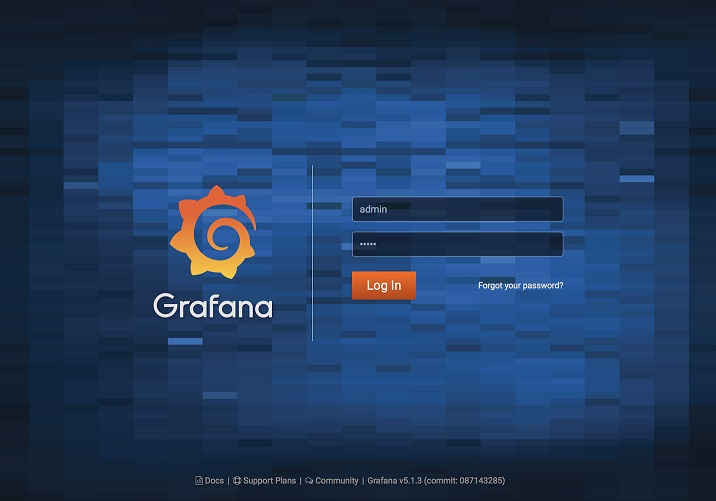

## 負荷状況のグラフ表示

以下のように表示されます。左半分のグラフがBaseコンテナの負荷状況で、右半分がアプリケーションコンテナの負荷状況のグラフです。

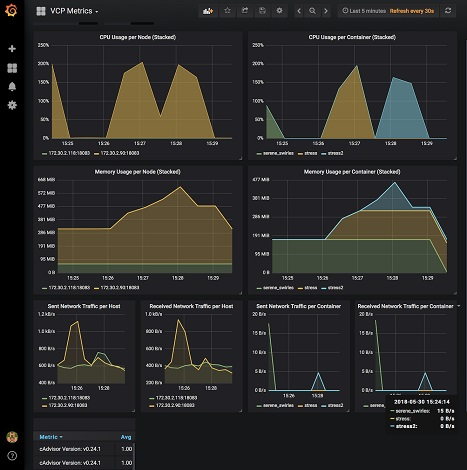

VCノードに負荷をかけるために、アプリケーションコンテナで stress コマンドを実行します。

In [27]:
# 60秒間だけ CPU x 2 とメモリ 128 MB を消費する
!ssh {ssh_opts} root@{ip_address} \
    /usr/local/bin/docker run -td --rm --name stress polinux/stress \
    stress --cpu 2 --io 1 --vm 2 --vm-bytes 128M --timeout 60s --verbose

Unable to find image 'polinux/stress:latest' locally
latest: Pulling from polinux/stress
627beaf3eaaf: Pulling fs layer
4de9f469a6f4: Pulling fs layer
627beaf3eaaf: Download complete
4de9f469a6f4: Verifying Checksum
4de9f469a6f4: Download complete
627beaf3eaaf: Pull complete
4de9f469a6f4: Pull complete
Digest: sha256:6d1825288ddb6b3cec8d3ac8a488c8ec2449334512ecb938483fc2b25cbbdb9a
Status: Downloaded newer image for polinux/stress:latest
18484b53c6729d7bad711d1c974ff11d1f3b0cef5f7e3e2ec47f85001010ad77


# VCノードのスケールアウト、スケールイン

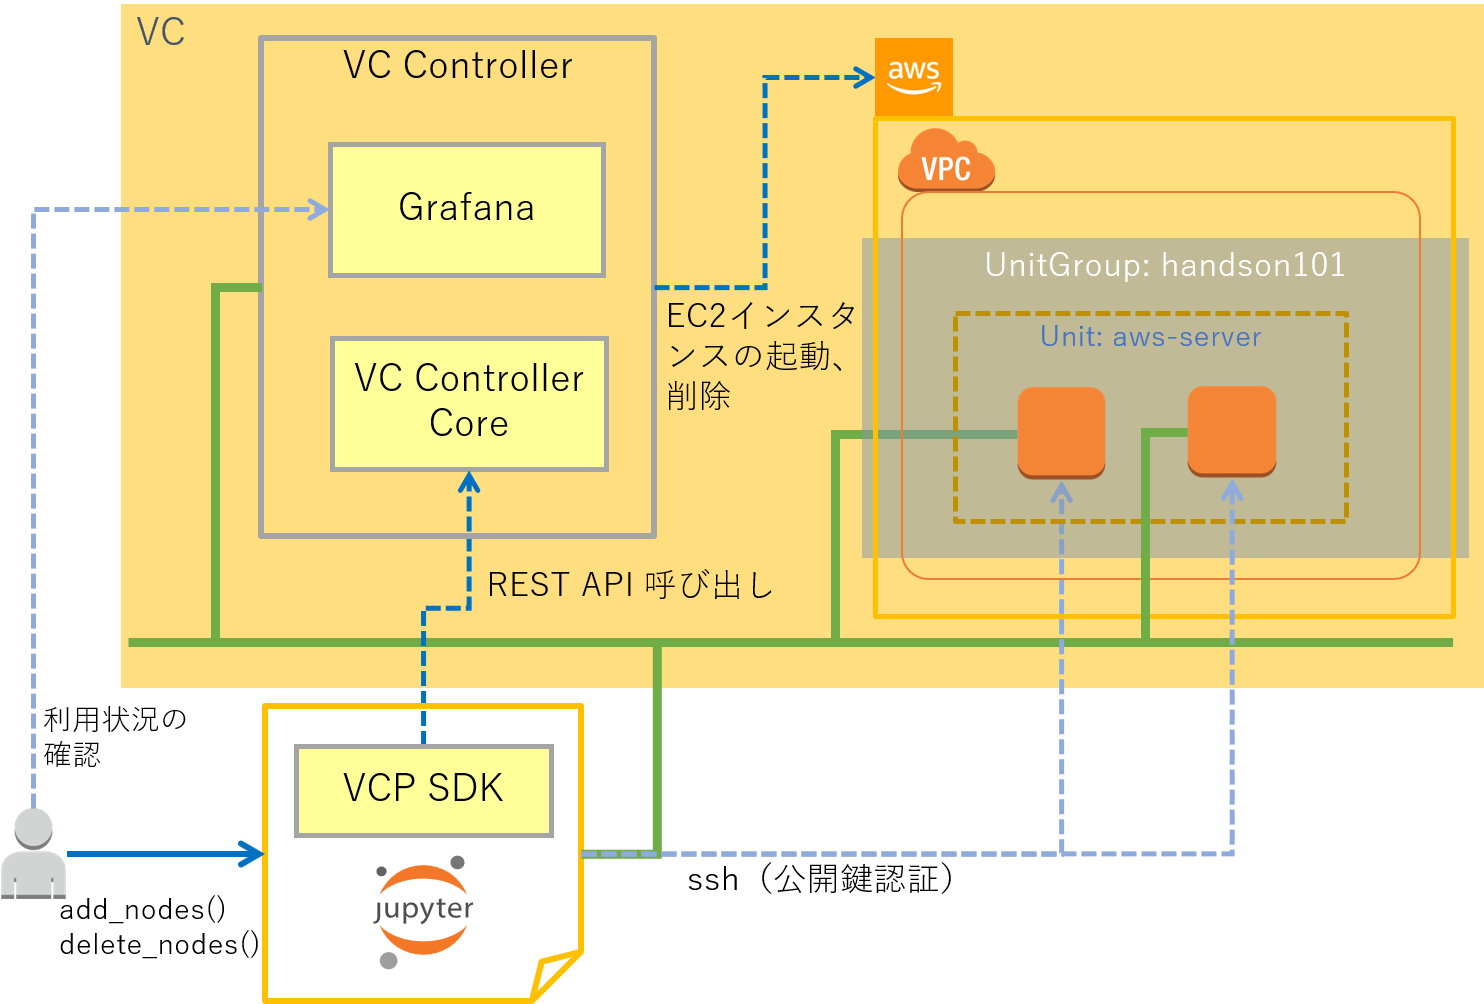

## VCノードのスケールアウト

Unitには `spec`オブジェクトに指定されている設定と同一の VCノードを作成する機能があります。その機能を利用して Unit にVCノードを追加してみます。

まず、現在のVCノードの状況を確認しておきます。

In [28]:
# VCノードの一覧を DataFrame で表示する
unit.df_nodes()

,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none


Unit に VCノードを追加するには`unit`オブジェクトに対して `add_nodes()` を呼び出します。

`add_node()`を呼び出すことで追加されるVCノードの数はデフォルトでは１ですが、パラメータ`num_add_nodes`を設定することで追加するVCノード数を変更することが出来ます。他にどんなパラメータを指定することが出来るかについては次のセルのように Codeセルの先頭で `?` を指定することで確認できます。

In [29]:
?unit.add_nodes

<!---
> `add_nodes()` の仕様については「[VCPSDK APIドキュメント](/handson/files/DOC/index.html#vcpsdk.vcpsdk.VcpUnitClass)」でも確認できます。
--->

では実際にVCノードを追加します。次のセルを実行するとUnitに VCノード が追加されます。

> VCノード の起動には 1分半～2分程度かかります。

In [30]:
unit.add_nodes()

2018-09-28 14:47:41,539 - INFO - INDEFINITE ... 0 sec
2018-09-28 14:47:46,746 - INFO - INDEFINITE ... 5 sec
2018-09-28 14:47:51,956 - INFO - INDEFINITE ... 10 sec
2018-09-28 14:47:57,180 - INFO - INDEFINITE ... 15 sec
2018-09-28 14:48:02,390 - INFO - INDEFINITE ... 20 sec
2018-09-28 14:48:07,604 - INFO - INDEFINITE ... 25 sec
2018-09-28 14:48:12,814 - INFO - INDEFINITE ... 30 sec
2018-09-28 14:48:18,027 - INFO - INDEFINITE ... 35 sec
2018-09-28 14:48:23,238 - INFO - INDEFINITE ... 40 sec
2018-09-28 14:48:28,448 - INFO - INDEFINITE ... 45 sec
2018-09-28 14:48:33,661 - INFO - INDEFINITE ... 50 sec
2018-09-28 14:48:38,896 - INFO - INDEFINITE ... 55 sec
2018-09-28 14:48:44,108 - INFO - INDEFINITE ... 60 sec
2018-09-28 14:48:49,333 - INFO - INDEFINITE ... 65 sec
2018-09-28 14:48:54,549 - INFO - INDEFINITE ... 70 sec
2018-09-28 14:48:59,760 - INFO - INDEFINITE ... 75 sec
2018-09-28 14:49:04,971 - INFO - unit aws-server is RUNNING
2018-09-28 14:49:04,972 - INFO - add_node completed.


VCノードの一覧表示をおこなってみます。VCノードが増えていることが確認できるはずです。

In [31]:
unit.df_nodes()

,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none
1,36,handson101,aws-server,RUNNING,2,f0fca9b0...,RUNNING,172.30.2.103,i-0ea151280eca0580f,VCP-020661f0-2402ae36,none


VCノード対して `ping` を行ってみます。

In [32]:
# Unit内のVCノードのIPアドレスのリストを取得する
ip_address = unit.find_ip_addresses()
print(ip_address)

# それぞれのIPアドレスに対して pingコマンドを実行する
for address in ip_address:
    !ping -c 5 {address}
    print()

['172.30.2.26', '172.30.2.103']
PING 172.30.2.26 (172.30.2.26): 56 data bytes
64 bytes from 172.30.2.26: icmp_seq=0 ttl=63 time=0.356 ms
64 bytes from 172.30.2.26: icmp_seq=1 ttl=63 time=0.277 ms
64 bytes from 172.30.2.26: icmp_seq=2 ttl=63 time=0.283 ms
64 bytes from 172.30.2.26: icmp_seq=3 ttl=63 time=0.336 ms
64 bytes from 172.30.2.26: icmp_seq=4 ttl=63 time=0.265 ms
--- 172.30.2.26 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev = 0.265/0.303/0.356/0.036 ms

PING 172.30.2.103 (172.30.2.103): 56 data bytes
64 bytes from 172.30.2.103: icmp_seq=0 ttl=63 time=0.479 ms
64 bytes from 172.30.2.103: icmp_seq=1 ttl=63 time=0.295 ms
64 bytes from 172.30.2.103: icmp_seq=2 ttl=63 time=0.377 ms
64 bytes from 172.30.2.103: icmp_seq=3 ttl=63 time=0.287 ms
64 bytes from 172.30.2.103: icmp_seq=4 ttl=63 time=0.296 ms
--- 172.30.2.103 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev 

追加で起動した VCノード は同じ Unit に属しているため同じ構成(cpu, memory, disk)になっています。そのことを確認するために、sshでログインして以下のコマンドを実行してみます。

* カーネルバージョン
  - uname -a
* CPU
  - cat /proc/cpuinfo
* メモリ量
  - free
* ディスク容量
  - df -h
  
> ただし aws では同じインスタンスタイプに複数種類の CPU が混在していることがあり CPU が微妙に異なることがあります。

In [33]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} uname -a
    print()

172.30.2.26:
Linux ip-172-30-2-26 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux

172.30.2.103:
Linux ip-172-30-2-103 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux



In [34]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} cat /proc/cpuinfo | grep 'model name'
    print()

172.30.2.26:
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz

172.30.2.103:
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz



In [35]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} free
    print()

172.30.2.26:
             total       used       free     shared    buffers     cached
Mem:       8173656     797956    7375700      12548      41444     510024
-/+ buffers/cache:     246488    7927168
Swap:            0          0          0

172.30.2.103:
             total       used       free     shared    buffers     cached
Mem:       8173656     752488    7421168      12548      25040     497356
-/+ buffers/cache:     230092    7943564
Swap:            0          0          0



In [36]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} df -h
    print()

172.30.2.26:
Filesystem                Size      Used Available Use% Mounted on
none                     14.6G      1.8G     12.1G  13% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/resolv.conf
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hostname
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker
none                      3.9G         0      3.9G   0% /tmp
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker/aufs

172.30.2.103:
Filesystem                Size      Used Available Use% Mounted on
none                     14.6G      1.8G     12.1G  13% /
tmpfs                     3.9G         0

先程と同様に、負荷をかけるためにそれぞれのVCノードでアプリケーションコンテナによる stress コマンドの実行を行います。

In [37]:
for idx, address in enumerate(ip_address):
    # 60秒間だけ CPU x 2 とメモリ 128 MB を消費する
    !ssh {ssh_opts} root@{address} \
        /usr/local/bin/docker run -td --rm --name stress-{idx} polinux/stress \
        stress --cpu 2 --io 1 --vm 2 --vm-bytes 128M --timeout 60s --verbose

52b9cec887b16d645039e9cb5c202c0ecafac81cd691994b29c80235df279407
Unable to find image 'polinux/stress:latest' locally
latest: Pulling from polinux/stress
627beaf3eaaf: Pulling fs layer
4de9f469a6f4: Pulling fs layer
627beaf3eaaf: Verifying Checksum
627beaf3eaaf: Download complete
4de9f469a6f4: Verifying Checksum
4de9f469a6f4: Download complete
627beaf3eaaf: Pull complete
4de9f469a6f4: Pull complete
Digest: sha256:6d1825288ddb6b3cec8d3ac8a488c8ec2449334512ecb938483fc2b25cbbdb9a
Status: Downloaded newer image for polinux/stress:latest
9aec4e17c4b8ce0dbe4d71a9b6009635146673299db27218728f598fca380a7c


[Grafana](/grafana/d/handson/vcp-metrics?refresh=5s)で利用状況を確認してみます。

## VCノードのスケールイン

現在Unitには２つのVCノードがありますが、そのうちの一つを削除してみます。

まず、現在のVCノードの状況を確認しておきます。

In [38]:
# VCノードの一覧を DataFrame で表示する
unit.df_nodes()

,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none
1,36,handson101,aws-server,RUNNING,2,f0fca9b0...,RUNNING,172.30.2.103,i-0ea151280eca0580f,VCP-020661f0-2402ae36,none


Unit から VCノードを削除するにはオブジェクト`unit`に対して `delete_nodes()` を呼び出します。

複数の VCノード のうちどのVCノード を削除するかを引数で指定することができます。ここでは`ip_address`パラメータを指定してVCノードに割り当てられている IPアドレスで VCノードを特定します。

> VCノードを特定するパラメータが指定されなかった場合は削除対象となる VCノードは VCP SDK によって自動的に選択されます。

VCノードを特定するための他のパラメータに指定方法については次のセルを実行すると表示される情報で確認してください。

In [39]:
?unit.delete_nodes

では実際にVCノードを削除します。まず削除対象とするVCノードのIPアドレスを確認します。スケールアウトの節で追加したVCノードのIPアドレスを指定することにします。

In [40]:
# 削除対象とするVCノードの IPアドレスを表示 
print(ip_address[-1])                         # 後から追加した VCノード を削除対象とする

172.30.2.103


次のセルを実行すると VCノード が Unit から削除されます。

> VCノード の削除には 1分～2分程度かかります。

In [41]:
# VCノードの削除
unit.delete_nodes(
    ip_address=ip_address[-1]     # IPアドレスで削除対象を指定する
)

2018-09-28 14:50:01,775 - INFO - INDEFINITE ... 0 sec
2018-09-28 14:50:06,980 - INFO - INDEFINITE ... 5 sec
2018-09-28 14:50:12,195 - INFO - INDEFINITE ... 10 sec
2018-09-28 14:50:17,408 - INFO - INDEFINITE ... 15 sec
2018-09-28 14:50:22,623 - INFO - INDEFINITE ... 20 sec
2018-09-28 14:50:27,838 - INFO - INDEFINITE ... 25 sec
2018-09-28 14:50:33,050 - INFO - INDEFINITE ... 30 sec
2018-09-28 14:50:38,267 - INFO - INDEFINITE ... 35 sec
2018-09-28 14:50:43,481 - INFO - INDEFINITE ... 40 sec
2018-09-28 14:50:48,698 - INFO - INDEFINITE ... 45 sec
2018-09-28 14:50:53,918 - INFO - INDEFINITE ... 50 sec
2018-09-28 14:50:59,132 - INFO - unit aws-server is RUNNING
2018-09-28 14:50:59,133 - INFO - deleted_node completed.


Unit内のVCノードの一覧を確認してみます。VCノードが減っていることが確認できるはずです。

In [42]:
unit.df_nodes()

,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none


先ほど取得した２つのVCノードのIPアドレスに対して `ping` を行ってみます。
削除されている VCノード に対する `ping` が失敗するので、次のセルは必ずエラーになるはずです。

In [43]:
for address in ip_address:
    !ping -c 5 {address}

PING 172.30.2.26 (172.30.2.26): 56 data bytes
64 bytes from 172.30.2.26: icmp_seq=0 ttl=63 time=0.276 ms
64 bytes from 172.30.2.26: icmp_seq=1 ttl=63 time=0.288 ms
64 bytes from 172.30.2.26: icmp_seq=2 ttl=63 time=0.254 ms
64 bytes from 172.30.2.26: icmp_seq=3 ttl=63 time=0.268 ms
64 bytes from 172.30.2.26: icmp_seq=4 ttl=63 time=0.277 ms
--- 172.30.2.26 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev = 0.254/0.273/0.288/0.000 ms
PING 172.30.2.103 (172.30.2.103): 56 data bytes
--- 172.30.2.103 ping statistics ---
5 packets transmitted, 0 packets received, 100% packet loss


RuntimeError: Unexpected exit code: 1

# 別のクラウド(Microsoft Azure)でVCノードを起動する

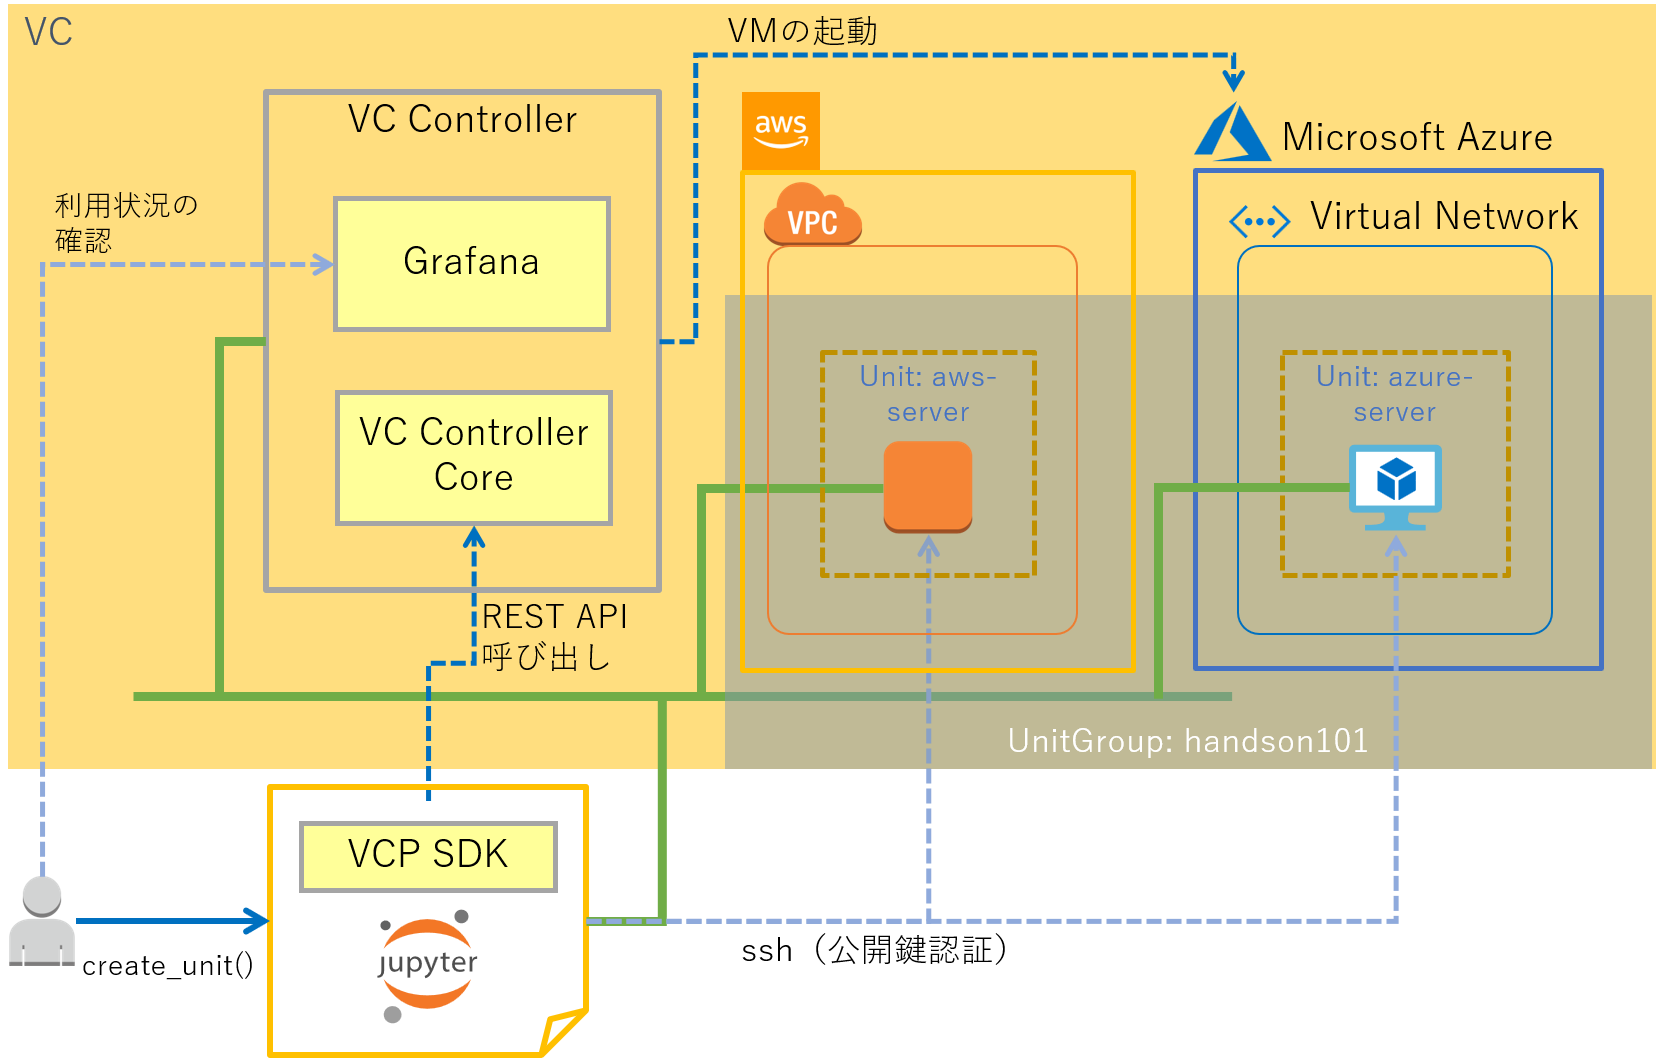

## Unit の追加

先程とは異なる構成のVCノードを追加するので、新たな Unit を作成します。

### VCノードのspecを指定する

awsの場合と同様 `spec` オブジェクトを作成します。

まずはMicrosoft Azure向け `flavor` の定義内容を確認してみます。

In [44]:
VcpSDK.df_flavors('azure')

,flavor,disk_size_gb,managed_disk_type,vm_size
0,small,40,Standard_LRS,Standard_B1s
1,medium,100,Standard_LRS,Standard_D3_v2
2,large,100,Premium_LRS,Standard_D4_v2


では、以下のパラメータを指定して `spec`オブジェクトを作成します。
* プロバイダ: azure
* flavor: medium

In [45]:
spec_azure = VcpSDK.get_spec('azure', 'medium')

作成した`spec_azure`の設定内容を確認してみます。

In [46]:
print(spec_azure)


azure
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': [], 'v': []}

        vm_size: Standard_D3_v2
        disk_size_gb: 100
        managed_disk_type: Standard_LRS
        ext_managed_disk: []
        cloud_image: default
        ip_address_list: []
    tags: 
        tags: {}


指定した `flavor`に対応する `vm_size`, `disk_size_gb` などが設定されていることが確認できます。

### sshの公開鍵設定

VCノードに登録するsshの公開鍵を `spec_azure`に設定します。先ほど aws 向けの`spec`に設定したのと同じ値を指定しています。

In [47]:
spec_azure.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

### specの設定内容を確認する

`spec_azure`の設定内容を確認してみます。

In [48]:
print(spec_azure)


azure
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}

        vm_size: Standard_D3_v2
        disk_size_gb: 100
        managed_disk_type: Standard_LRS
        ext_managed_disk: []
        cloud_image: default
        ip_address_list: []
    tags: 
        tags: {}


aws向けに最初に作成した `spec`オブジェクトと`spec_azure`との差分を確認してみます。

> `spec`オブジェクトの内部では aws は `instance_type`、azure は`vm_size` などそれぞれのクラウドプロバイダに応じたパラメータが設定されていることが確認できます。

In [49]:
from difflib import unified_diff
import sys

sys.stdout.writelines(unified_diff(
    str(spec).splitlines(True),
    str(spec_azure).splitlines(True),
    fromfile='aws',
    tofile='azure',
))

--- aws
+++ azure
@@ -1,10 +1,10 @@
 
-aws
+azure
 ------------------------
 
     cci_version: "1.0"
-    name: aws-server
+    name: 
     description: 
     private_network: default
     num_nodes: 1
@@ -12,10 +12,13 @@
     recovery_mode: none
     params:
         {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
-    instance_type: m4.large
-    volume_size: 15
-    volume_type: standard
-    volume_id: []
-    cloud_image: default
-    tags: {}
+
+        vm_size: Standard_D3_v2
+        disk_

### Unitの作成とVCノードの起動

まず作成前のUnitGroup状態を確認しておきます。

In [50]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,36,handson101,RUNNING,2402ae36...,2018/09/28 05:33:28 UTC,aws-server,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none


Unitを作成します。

> 処理が完了するまでには 2～5分程度かかります。

In [51]:
# Unitの作成（同時に VCノードが作成される）
unit2 = unit_group.create_unit(
            'azure-server',    # Unit 名
            spec_azure         # spec オブジェクト
        )

2018-09-28 14:52:55,820 - INFO - BOOTING ... 0 sec
2018-09-28 14:53:01,059 - INFO - BOOTING ... 5 sec
2018-09-28 14:53:06,304 - INFO - BOOTING ... 10 sec
2018-09-28 14:53:11,542 - INFO - BOOTING ... 15 sec
2018-09-28 14:53:16,787 - INFO - BOOTING ... 20 sec
2018-09-28 14:53:22,028 - INFO - BOOTING ... 25 sec
2018-09-28 14:53:27,275 - INFO - BOOTING ... 30 sec
2018-09-28 14:53:32,536 - INFO - BOOTING ... 35 sec
2018-09-28 14:53:37,780 - INFO - BOOTING ... 40 sec
2018-09-28 14:53:43,018 - INFO - BOOTING ... 45 sec
2018-09-28 14:53:48,264 - INFO - BOOTING ... 50 sec
2018-09-28 14:53:53,499 - INFO - BOOTING ... 55 sec
2018-09-28 14:53:58,742 - INFO - BOOTING ... 60 sec
2018-09-28 14:54:03,982 - INFO - BOOTING ... 65 sec
2018-09-28 14:54:09,228 - INFO - BOOTING ... 70 sec
2018-09-28 14:54:14,465 - INFO - BOOTING ... 75 sec
2018-09-28 14:54:19,705 - INFO - BOOTING ... 80 sec
2018-09-28 14:54:24,947 - INFO - BOOTING ... 85 sec
2018-09-28 14:54:30,205 - INFO - BOOTING ... 90 sec
2018-09-28 14:

Unit作成後の状態を確認します。Unit とVCノードがそれぞれ２つあることが確認できるはずです。VCノード一覧ではそれぞれのVCノードの unit_name が異なることが確認できるはずです。またawsとazureのVCノードには**異なるサブネット**のIPアドレスが割り当てられていることが確認できます。

> 各プロバイダにどのようなサブネットを割り当てているのかについては[VCP Manager Web UI](https://vcpdev.ecloud.nii.ac.jp/vcp/v1/ui/occmgr/menu/occtrs) で確認ができます。

In [52]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,36,handson101,RUNNING,2402ae36...,2018/09/28 05:33:28 UTC,aws-server,RUNNING
1,compute,36,handson101,RUNNING,2402ae36...,2018/09/28 05:33:28 UTC,azure-server,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,36,handson101,aws-server,RUNNING,1,d983afca...,RUNNING,172.30.2.26,i-002140ab6e2fa858a,VCP-020661f0-2402ae36,none
1,36,handson101,azure-server,RUNNING,1,f3065992...,RUNNING,172.21.1.4,xxxxxxxx...,VCP-020661f0-2402ae36,none


VCノードに対して`ping` を実行してみます。

In [53]:
# UnitGroup内にあるVCノードのIPアドレスリストを取得する
ip_address = unit_group.find_ip_addresses()

# それぞれのVCノードに対してpingを実行する
for address in ip_address:
    !ping -c 5 {address}
    print()

PING 172.30.2.26 (172.30.2.26): 56 data bytes
64 bytes from 172.30.2.26: icmp_seq=0 ttl=63 time=0.331 ms
64 bytes from 172.30.2.26: icmp_seq=1 ttl=63 time=0.372 ms
64 bytes from 172.30.2.26: icmp_seq=2 ttl=63 time=0.330 ms
64 bytes from 172.30.2.26: icmp_seq=3 ttl=63 time=0.290 ms
64 bytes from 172.30.2.26: icmp_seq=4 ttl=63 time=0.296 ms
--- 172.30.2.26 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev = 0.290/0.324/0.372/0.029 ms

PING 172.21.1.4 (172.21.1.4): 56 data bytes
64 bytes from 172.21.1.4: icmp_seq=0 ttl=60 time=9.924 ms
64 bytes from 172.21.1.4: icmp_seq=1 ttl=60 time=9.903 ms
64 bytes from 172.21.1.4: icmp_seq=2 ttl=60 time=9.826 ms
64 bytes from 172.21.1.4: icmp_seq=3 ttl=60 time=13.539 ms
64 bytes from 172.21.1.4: icmp_seq=4 ttl=60 time=10.129 ms
--- 172.21.1.4 ping statistics ---
5 packets transmitted, 5 packets received, 0% packet loss
round-trip min/avg/max/stddev = 9.826/10.664/13.539/1.441 ms



VCPでは複数の異なるクラウドを仮想的に一つの計算基盤（仮想クラウド）のように扱える機能を提供しています。そのため異なるクラウド(aws, azure)で起動したVCノードであっても、追加の設定なしに互いに通信することができます。そのことを確認するために、作成した２つの VCノード の一方から他方に対して `ping` を行ってみます。

In [54]:
# pingを実行するVCノードのIPアドレスを表示する
print(ip_address[0])
print()

!ssh {ssh_opts} root@{ip_address[0]} \
    ping -c 10 {ip_address[1]}

172.30.2.26

PING 172.21.1.4 (172.21.1.4): 56 data bytes
64 bytes from 172.21.1.4: seq=0 ttl=61 time=9.711 ms
64 bytes from 172.21.1.4: seq=1 ttl=61 time=10.014 ms
64 bytes from 172.21.1.4: seq=2 ttl=61 time=10.051 ms
64 bytes from 172.21.1.4: seq=3 ttl=61 time=10.183 ms
64 bytes from 172.21.1.4: seq=4 ttl=61 time=9.785 ms
64 bytes from 172.21.1.4: seq=5 ttl=61 time=9.601 ms
64 bytes from 172.21.1.4: seq=6 ttl=61 time=9.917 ms
64 bytes from 172.21.1.4: seq=7 ttl=61 time=10.094 ms
64 bytes from 172.21.1.4: seq=8 ttl=61 time=10.081 ms
64 bytes from 172.21.1.4: seq=9 ttl=61 time=9.960 ms

--- 172.21.1.4 ping statistics ---
10 packets transmitted, 10 packets received, 0% packet loss
round-trip min/avg/max = 9.601/9.939/10.183 ms


逆方向で同様のことを行ってみます。

In [55]:
# pingを実行するVCノードのIPアドレスを表示する
print(ip_address[1])
print()

!ssh {ssh_opts} root@{ip_address[1]} \
    ping -c 10 {ip_address[0]}

172.21.1.4

PING 172.30.2.26 (172.30.2.26): 56 data bytes
64 bytes from 172.30.2.26: seq=0 ttl=60 time=10.165 ms
64 bytes from 172.30.2.26: seq=1 ttl=60 time=10.042 ms
64 bytes from 172.30.2.26: seq=2 ttl=60 time=9.632 ms
64 bytes from 172.30.2.26: seq=3 ttl=60 time=9.945 ms
64 bytes from 172.30.2.26: seq=4 ttl=60 time=9.906 ms
64 bytes from 172.30.2.26: seq=5 ttl=60 time=9.774 ms
64 bytes from 172.30.2.26: seq=6 ttl=60 time=9.692 ms
64 bytes from 172.30.2.26: seq=7 ttl=60 time=9.914 ms
64 bytes from 172.30.2.26: seq=8 ttl=60 time=9.688 ms
64 bytes from 172.30.2.26: seq=9 ttl=60 time=9.762 ms

--- 172.30.2.26 ping statistics ---
10 packets transmitted, 10 packets received, 0% packet loss
round-trip min/avg/max = 9.632/9.852/10.165 ms


## VCノードに ssh でログインして操作する

Azureに追加で起動した VCノード は aws とは異なる構成(cpu, memory, disk)になってるはずです。そのことを確認するために、sshでログインして以下のコマンドを実行してみます。

* カーネルバージョン
  - uname -a
* CPU
  - cat /proc/cpuinfo
* メモリ量
  - free
* ディスク容量
  - df -h

In [56]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} uname -a
    print()

172.30.2.26:
Linux ip-172-30-2-26 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux

172.21.1.4:
Linux f3065992 4.15.0-1021-azure #21~16.04.1-Ubuntu SMP Fri Aug 10 12:36:09 UTC 2018 x86_64 Linux



In [57]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} cat /proc/cpuinfo | grep 'model name'
    print()

172.30.2.26:
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz

172.21.1.4:
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz



In [58]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} free
    print()

172.30.2.26:
             total       used       free     shared    buffers     cached
Mem:       8173656     812552    7361104      12548      56548     510028
-/+ buffers/cache:     245976    7927680
Swap:            0          0          0

172.21.1.4:
             total       used       free     shared    buffers     cached
Mem:      14362156    1496148   12866008       8932      26580     753080
-/+ buffers/cache:     716488   13645668
Swap:            0          0          0



In [59]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} df -h
    print()

172.30.2.26:
Filesystem                Size      Used Available Use% Mounted on
none                     14.6G      1.8G     12.1G  13% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/resolv.conf
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hostname
/dev/xvda1               14.6G      1.8G     12.1G  13% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker
none                      3.9G         0      3.9G   0% /tmp
/dev/xvda1               14.6G      1.8G     12.1G  13% /var/lib/docker/aufs

172.21.1.4:
Filesystem                Size      Used Available Use% Mounted on
none                     96.9G      1.7G     95.2G   2% /
tmpfs                     6.8G         0  

最後に先程と同様に、負荷をかけるためにそれぞれのVCノードで stress コマンドを実行します。これまで同様 stressコマンドはアプリケーションコンテナとして実行します。

In [60]:
for idx, address in enumerate(ip_address):
    # 60秒間だけ CPU x 2 とメモリ 128 MB を消費する
    !ssh {ssh_opts} root@{address} \
        /usr/local/bin/docker run -td --rm --name stress-{idx} polinux/stress \
        stress --cpu 2 --io 1 --vm 2 --vm-bytes 128M --timeout 60s --verbose

d95efab54d127f5ddbceabd3acac0262f0d23de7601e523a081bd4f86365e056
Unable to find image 'polinux/stress:latest' locally
latest: Pulling from polinux/stress
627beaf3eaaf: Pulling fs layer
4de9f469a6f4: Pulling fs layer
627beaf3eaaf: Verifying Checksum
627beaf3eaaf: Download complete
4de9f469a6f4: Verifying Checksum
4de9f469a6f4: Download complete
627beaf3eaaf: Pull complete
4de9f469a6f4: Pull complete
Digest: sha256:6d1825288ddb6b3cec8d3ac8a488c8ec2449334512ecb938483fc2b25cbbdb9a
Status: Downloaded newer image for polinux/stress:latest
1352cf9a44c0f53a9b2f6a05454c3912630600e77aa93e7856808e907805c138


[Grafana](/grafana/d/handson/vcp-metrics?refresh=5s)で利用状況を確認してみます。

# 全てのVCノードを削除する

ここまで作成した全てのリソース（UnitGroup, Unit、VCノード）を削除します。

> 全てのリソースの削除には 4～5分程度かかります。

In [61]:
unit_group.cleanup()

2018-09-28 15:03:35,735 - INFO - aws-server is DELETING
azure-server is DELETING ... 0 sec
2018-09-28 15:03:41,030 - INFO - aws-server is DELETING
azure-server is DELETING ... 5 sec
2018-09-28 15:03:46,321 - INFO - aws-server is DELETING
azure-server is DELETING ... 10 sec
2018-09-28 15:03:51,635 - INFO - aws-server is DELETING
azure-server is DELETING ... 15 sec
2018-09-28 15:03:56,921 - INFO - aws-server is DELETING
azure-server is DELETING ... 20 sec
2018-09-28 15:04:02,213 - INFO - aws-server is DELETING
azure-server is DELETING ... 25 sec
2018-09-28 15:04:07,499 - INFO - aws-server is DELETING
azure-server is DELETING ... 30 sec
2018-09-28 15:04:12,784 - INFO - aws-server is DELETING
azure-server is DELETING ... 35 sec
2018-09-28 15:04:18,071 - INFO - aws-server is DELETING
azure-server is DELETING ... 40 sec
2018-09-28 15:04:23,358 - INFO - aws-server is DELETING
azure-server is DELETING ... 45 sec
2018-09-28 15:04:28,648 - INFO - aws-server is DELETING
azure-server is DELETING .

削除後の状態を確認してみます。

In [62]:
# UnitGroupの一覧を DataFrame で表示する
vcp.df_ugroups()

,vcno,vctype,vcname,state,vcid,cdate
